
# E1 - Model Deployment in Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [ ]:
%matplotlib inline
import pandas as pd

In [ ]:
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

In [ ]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [ ]:
data.shape

(500000, 6)

In [ ]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

In [ ]:
data.dtypes

,0
Price,int64
Year,int64
Mileage,int64
State,object
Make,object
Model,object


In [ ]:
data.dtypes

,0
Price,int64
Year,int64
Mileage,int64
State,object
Make,object
Model,object


In [ ]:
data.dtypes

,0
Price,int64
Year,int64
Mileage,int64
State,object
Make,object
Model,object


# Exercise P0.1 (50%)-LEONARDO

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process.


**ANSWER**

We start by importing the libraries needed to develop the model.

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression  # Example model
from sklearn.metrics import mean_squared_error  # Example metric
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder  # Import OneHotEncoder
from sklearn.model_selection import train_test_split

Before we develop the model we need a base line to looking for the principal variables and the best way how we can improve the model. So, we start the develop with a linear regression model looking foward the following steps:

1. Data preparation (Feature Enginering is not performed in this initial model).
2. Data splitting into training and testing.
3. One-Hot coding for categorical variables.
4. Model initialisation (Linear Regression).
5. K-Fold Cross Validation (10 Folds).
6. Calculation of model performance metrics.
7. Final model evaluation.



In [ ]:
#1. Data Preparation we identied the independent an dependent variables
X = data[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = data['Price']

#2. Split dataset in train and test (0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#3. For the categorical variable we implement One-Hot Encoder.
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

### We adjust the encoder an transform the categories
X_train_encoded = encoder.fit_transform(X_train[['State', 'Make', 'Model']])

### After the encoder we identified the name of the principal variables
encoded_feature_names = encoder.get_feature_names_out(['State', 'Make', 'Model'])

### And crate a dataframe with the variables
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)

### After, we concatenate the numeric variables (Year,Mileage)
X_train_final = pd.concat([X_train[['Year', 'Mileage']], X_train_encoded_df], axis=1)

#4. The Fourth step is to incializate the Linear Regression Model
linear_model = LinearRegression()

#5. Then we made a Cross Validation with K-Folds (10 folds)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mape_scores = []
rmse_scores = []

for train_index, val_index in kf.split(X_train_final):
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

##### We Adjust the linear regression model
    linear_model.fit(X_train_fold, y_train_fold)

##### and Made the Predictions
    y_pred = linear_model.predict(X_val_fold)

# 6. Finally we calculate the performance meassure
### calculate MAPE y RMSE
    mape = mean_absolute_percentage_error(y_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))

### Add pointers
    mape_scores.append(mape)
    rmse_scores.append(rmse)

#7 And Evaluate the model
print(f"Promedio de MAPE en todos los folds: {np.mean(mape_scores)}")
print(f"Promedio de RMSE en todos los folds: {np.mean(rmse_scores)}")

Promedio de MAPE en todos los folds: 0.16444665758128174
Promedio de RMSE en todos los folds: 4407.738310981319


Once the model has been run with the cross validation we obtain the baseline of the model with the MAPE and RMSE metrics with values 0.1644 and 4407.73 respectively, with this baseline we will proceed to perform the corresponding Feature Engineering procedure to improve the performance metrics.

# **Data Preparation/Feature Engineering**

Starting from the baseline and taking into account that in the exploratory phase of the data a large number of categories have been identified for the variables ‘Model’, ‘State’ and ‘Make’, a good approach to achieve a reduction of variable categories is to apply the clustering method and identify an optimal grouping strategy. In clustering, the Elbow method is applied to visually inspect the point on the graph that most optimizes the WCSS to determine the number of categories by which each variable should be reduced

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def find_optimal_clusters_elbow(data, feature, max_clusters=10):
    """Finds the optimal number of clusters for a categorical feature using the elbow method.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature (str): The name of the categorical feature.
        max_clusters (int, optional): The maximum number of clusters to consider. Defaults to 10.

    Returns:
        int: The optimal number of clusters.
    """

    # 1. Encode the categorical feature (replace with your preferred encoding method)

    !pip install category_encoders
    import category_encoders as ce
    encoder = ce.TargetEncoder(cols=[feature])
    data_encoded = encoder.fit_transform(data[[feature]], data['Price'])


    # 2. Calculate WCSS for different numbers of clusters
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data_encoded)
        wcss.append(kmeans.inertia_)

    # 3. Find the elbow point (visually or using a more automated approach)

    plt.plot(range(1, max_clusters + 1), wcss)
    plt.title(f'Elbow Method for {feature}')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS')
    plt.show()

    return #optimal_k

We apply the method for ‘Model’ variable.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.7 MB/s eta 0:00:00


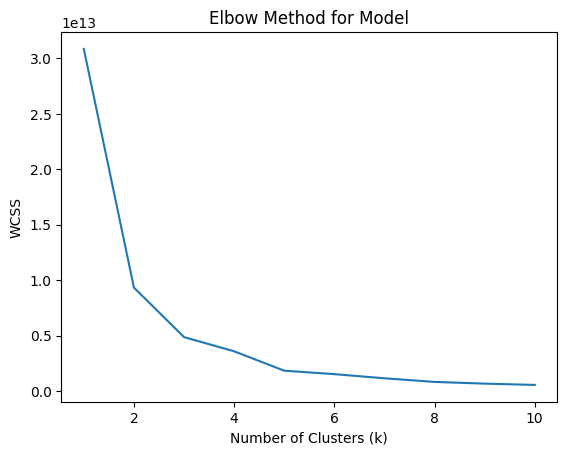

Optimal number of clusters for Model: None


In [ ]:
optimal_k_model = find_optimal_clusters_elbow(data, 'Model')
print(f"Optimal number of clusters for Model: {optimal_k_model}")

According to the Elbow Method, the optimal number of Categories for the **Model** Variable is **5**

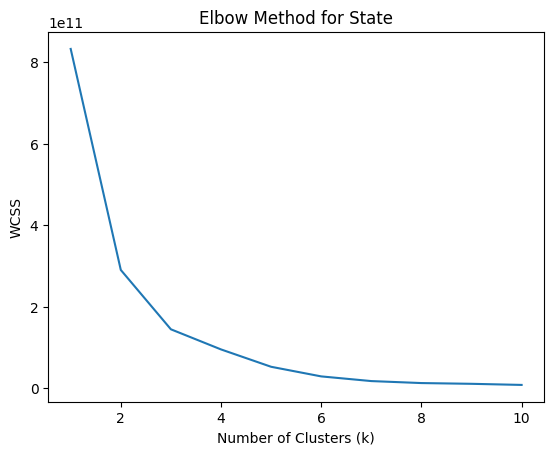

Optimal number of clusters for Model: None


In [ ]:
optimal_k_model2 = find_optimal_clusters_elbow(data, 'State')
print(f"Optimal number of clusters for Model: {optimal_k_model2}")

According to the Elbow Method, the optimal number of Categories for the **State** Variable is **5**

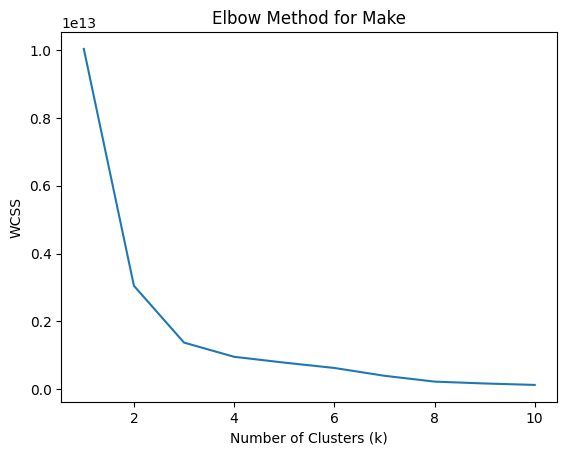

Optimal number of clusters for Model: None


In [ ]:
optimal_k_model3 = find_optimal_clusters_elbow(data, 'Make')
print(f"Optimal number of clusters for Model: {optimal_k_model3}")

According to the Elbow Method, the optimal number of Categories for the **Make** Variable is **4**

Closing, the categories of variables can be grouped as follows:

1.   "**Model**" : 5.
2.   "**State**" : 5.
3.   "**Make**" : 4.




With the results of the clusters, the reduction of variables is then carried out.

In [ ]:
import pandas as pd

def reduce_categories_by_price(data, feature, n_categories):
    """Reduces a categorical feature to a specified number of categories based on average price.

    Args:
        data (pd.DataFrame): The input DataFrame.
        feature (str): The name of the categorical feature to reduce.
        n_categories (int, optional): The desired number of categories. Defaults to 3.

    Returns:
        pd.DataFrame: The DataFrame with the reduced categorical feature.
    """

    # Calculate average price for each category
    category_prices = data.groupby(feature)['Price'].mean().sort_values()

    # Divide categories into n_categories quantiles based on average price
    category_bins = pd.qcut(category_prices, q=n_categories, labels=False, duplicates='drop')

    # Create a dictionary mapping original categories to new categories
    category_mapping = dict(zip(category_prices.index, category_bins))

    # Replace original categories with new categories in the DataFrame
    data[feature] = data[feature].map(category_mapping)

    #If mapping dict has less than n_categories items, fill values that weren't mapped with -1
    if len(category_mapping) < n_categories:
        for i in range(n_categories):
            if i not in data[feature].unique():
                data[feature] = data[feature].fillna(i)

    return data

# Apply the function to reduce categories for 'State', 'Make', and 'Model'
data = reduce_categories_by_price(data, 'Model',5)
data = reduce_categories_by_price(data, 'State',5)
data = reduce_categories_by_price(data, 'Make',4)
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,0,1,3
1,21250,2016,25741,1,2,3
2,20925,2016,24633,1,0,2
3,14500,2012,84026,3,2,3
4,32488,2013,22816,2,2,4


Also, a part of the reduced variables we create a new variable "Car age" wich represent the how old is the car and also we try to reduce the effect of the atipical mileage data usint the logarithm.

In [ ]:
# Calculate car age
data['Car_Age'] = 2025 - data['Year']

# Calculate the logarithm of Mileage
data['Log_Mileage'] = np.log1p(data['Mileage'])

# **First Model XGBoost**

Once we train the Linear Regression Model the first model we want to train is a XGBoost using GridSearch for now the best hyperparameter and then evaluate it, with the KFolds=10

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.model_selection import GridSearchCV


# Prepare the data
X = data[['Year', 'State', 'Make', 'Model','Car_Age','Log_Mileage']]
y = data['Price']

# Split Data Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = encoder.fit_transform(X_train[['State', 'Make', 'Model']])
encoded_feature_names = encoder.get_feature_names_out(['State', 'Make', 'Model'])
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_train_final = pd.concat([X_train[['Year','Car_Age', 'Log_Mileage']], X_train_encoded_df], axis=1)


# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                            eval_metric='rmse',  # Agregar eval_metric
                            seed=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',  # Cambiar scoring
                          cv=5, n_jobs=-1)


# Perform the grid search
grid_search.fit(X_train_final, y_train)


# Get the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Lowest RMSE found: ", np.abs(grid_search.best_score_))  # Imprimir el RMSE directamente

# Use the best model for predictions and further evaluation.
best_xgb_model = grid_search.best_estimator_

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.9}
Lowest RMSE found:  5064.49482421875


In [ ]:
# Use the best model from the grid search to evaluate with RMSE and MAPE
best_xgb_model = grid_search.best_estimator_

kf = KFold(n_splits=10, shuffle=True, random_state=42)
mape_scores = []
rmse_scores = []

for train_index, val_index in kf.split(X_train_final):
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the best model
    best_xgb_model.fit(X_train_fold, y_train_fold)

    # Make predictions
    y_pred = best_xgb_model.predict(X_val_fold)

    # Calculate MAPE and RMSE
    mape = mean_absolute_percentage_error(y_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))

    # Store the scores
    mape_scores.append(mape)
    rmse_scores.append(rmse)

# Print the average scores
print(f"Average MAPE across all folds: {np.mean(mape_scores)}")
print(f"Average RMSE across all folds: {np.mean(rmse_scores)}")

Average MAPE across all folds: 0.17034565508365632
Average RMSE across all folds: 5064.4225611218335


Below are the results of XGBoost without the hyperparameter search and the best model for MAPE indicator will be the one we evaluate. The model uses KFolds with 10 folds.

Only the categories are reduced to the model because reducing the dimensionality of the variables "State" and "Make" worsens the quality of the model according to the results obtained with them. If you want to check it you can "activate" the lines

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Assuming 'data' is your DataFrame with 'Price', 'Year', 'Mileage', 'Make', 'Model' columns

# 1. Prepare the data
X = data[['Year', 'Mileage', "State", 'Make', 'Model']]
y = data['Price']

# 2. One-hot encode categorical features
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoded_features = encoder.fit_transform(X[['Make', 'Model']])
encoded_feature_names = encoder.get_feature_names_out(['Make', 'Model'])
X_encoded = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=X.index)
X = pd.concat([X[['Year', 'Mileage']], X_encoded], axis=1)

# 3. K-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mape_scores = []
rmse_scores = []  # List to store RMSE scores
predictions = []  # Store predictions for each fold

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # 4. Train XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    # 5. Make predictions and evaluate
    y_pred = model.predict(X_val)
    mape = mean_absolute_percentage_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # Calculate RMSE
    mape_scores.append(mape)
    rmse_scores.append(rmse)  # Add RMSE to the list
    predictions.extend(y_pred)  # Add predictions to the list

# 6. Calculate average MAPE and RMSE
avg_mape = np.mean(mape_scores)
avg_rmse = np.mean(rmse_scores)  # Calculate average RMSE
print(f"Average MAPE across 10 folds: {avg_mape}")
print(f"Average RMSE across 10 folds: {avg_rmse}")  # Print average RMSE

# 7. Add predictions to the original DataFrame (optional)
data['Predicted_Price'] = predictions

Average MAPE across 10 folds: 0.17187687754631042
Average RMSE across 10 folds: 5108.708278333839


**SECOND MODEL-LINEAR REGRESSION ADJUSTING ATIPICAL DATA WITHOUT AFFECTING CATEGORICAL VARIABLES**

Through many trial and error tests, we found that by not dummifying or changing the number of categories of the categorical variables and only reducing the impact of outliers in "Mileage", along with the creation of the "Car_Age" variable, an improvement in the RMSE indicator was found.

In [ ]:
# Preparar los datos
data1 = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

# Calculate car age
data1['Car_Age'] = 2025 - data1['Year']

# Calculate the logarithm of Mileage
data1['Log_Mileage'] = np.log1p(data1['Mileage'])



X = data1[['Year', 'State', 'Make', 'Model','Car_Age','Log_Mileage']]
y = data1['Price']

# Split Data Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un objeto OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Ajustar el encoder a los datos de entrenamiento y transformarlos
X_train_encoded = encoder.fit_transform(X_train[['State', 'Make', 'Model']])

# Obtener los nombres de las características después de la codificación
encoded_feature_names = encoder.get_feature_names_out(['State', 'Make', 'Model'])

# Crear un DataFrame con las características codificadas
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)

# Concatenar las características codificadas con las características numéricas
X_train_final = pd.concat([X_train[['Year','Car_Age','Log_Mileage']], X_train_encoded_df], axis=1)

# Inicializar el modelo de regresión lineal
linear_model2 = LinearRegression()

# Validación cruzada KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mape_scores = []
rmse_scores = []

for train_index, val_index in kf.split(X_train_final):
    X_train_fold, X_val_fold = X_train_final.iloc[train_index], X_train_final.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Ajustar el modelo de regresión lineal
    linear_model2.fit(X_train_fold, y_train_fold)

    # Hacer predicciones
    y_pred = linear_model2.predict(X_val_fold)

    # Calcular MAPE y RMSE
    mape = mean_absolute_percentage_error(y_val_fold, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))

    # Agregar las puntuaciones
    mape_scores.append(mape)
    rmse_scores.append(rmse)

# Imprimir las puntuaciones promedio
print(f"Promedio de MAPE en todos los folds: {np.mean(mape_scores)}")
print(f"Promedio de RMSE en todos los folds: {np.mean(rmse_scores)}")

Promedio de MAPE en todos los folds: 0.16795323088863923
Promedio de RMSE en todos los folds: 4488.911313713497


**THIRD MODEL- ANN**

Why is this structure suitable for prediction in your case?

Regression problem: You are trying to predict a continuous value (car price), which makes a regression neural network structure suitable. The output layer without activation function and the MSE loss function are typical in this type of problems. Problem complexity: Predicting the price of a car depends on several features, some with non-linear relationships. The network structure with multiple dense layers and the relu activation function allows to model this complexity. Number of features: The number of neurons in the first hidden layer (128) is related to the number of input features. This gives the network enough capacity to learn from the features, due to we have a lot Pyramid structure: Gradual reduction of neurons in the hidden layers helps the network to learn more abstract and refined representations of the data, which can improve the prediction accuracy. In summary, this neural network structure is a good choice for your car price prediction problem because it is a typical structure for regression, has the ability to model the complexity of the problem, and uses a configuration of layers and neurons that is well suited to the number of features and the nature of the data.

It is always advisable to experiment with different neural network structures and configurations to find the one that best fits your specific problem.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load your data (replace 'your_data.csv' with the actual file path)
# Assuming 'data' is your DataFrame with 'Price', 'Year', 'Mileage', 'State', 'Make', 'Model' columns
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

# Feature Engineering (same as before)
data['Car_Age'] = 2025 - data['Year']
data['Log_Mileage'] = np.log1p(data['Mileage'])


# Prepare the data
X = data[['Year', 'State', 'Make', 'Model', 'Car_Age', 'Log_Mileage']]
y = data['Price']

# Split Data Train and Test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-hot encoding for categorical features and scaling for numerical features
numerical_features = ['Year', 'Car_Age', 'Log_Mileage']
categorical_features = ['State', 'Make', 'Model']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)

# Define the ANN model
modelANN = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1) # Output layer (no activation for regression)
])

# Compile the model
#model.compile(optimizer='adam', loss='mse', metrics=['mae']) # Mean Squared Error
modelANN.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

# Train the model
history = modelANN.fit(X_train_processed, y_train, epochs=50, batch_size=32, validation_data=(X_val_processed, y_val))

# Make predictions on the validation set
y_pred = modelANN.predict(X_val_processed).flatten()

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Load your data (replace 'your_data.csv' with the actual file path)
# Assuming 'data' is your DataFrame with 'Price', 'Year', 'Mileage', 'State', 'Make', 'Model' columns
data3 = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

# Feature Engineering (same as before)
data3['Car_Age'] = 2025 - data3['Year']
data3['Log_Mileage'] = np.log1p(data3['Mileage'])

# Prepare the data
X = data3[['Year', 'State', 'Make', 'Model', 'Car_Age', 'Log_Mileage']]
y = data3['Price']

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing: One-hot encoding for categorical features and scaling for numerical features
numerical_features = ['Year', 'Car_Age', 'Log_Mileage']
categorical_features = ['State', 'Make', 'Model']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)


def build_and_train_model(epochs, num_neurons, num_layers):
    modelANN2 = keras.Sequential()
    modelANN2.add(layers.Dense(num_neurons, activation='relu', input_shape=(X_train_processed.shape[1],)))
    for _ in range(num_layers - 1):
        modelANN2.add(layers.Dense(num_neurons, activation='relu'))
    modelANN2.add(layers.Dense(1))  # Output layer
    modelANN2.compile(optimizer='adam', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])
    modelANN2.fit(X_train_processed, y_train, epochs=epochs, batch_size=32, verbose=0) #verbose=0 to hide training output
    return modelANN2

#Hyperparameter search (example - adjust as needed)
best_rmse = float('inf')
best_hyperparams = {}

for epochs in [50, 100]: #Example epochs values
    for num_neurons in [64, 128]: # Example neuron values
        for num_layers in [2, 3]: # Example number of layers
            modelANN2 = build_and_train_model(epochs, num_neurons, num_layers)
            y_pred = modelANN2.predict(X_val_processed).flatten()
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))

            if rmse < best_rmse:
                best_rmse = rmse
                best_hyperparams = {'epochs': epochs, 'num_neurons': num_neurons, 'num_layers': num_layers}

print(f"Best Hyperparameters: {best_hyperparams}, RMSE: {best_rmse}")

# Train final model with best hyperparameters
final_modelANN2 = build_and_train_model(**best_hyperparams)
y_pred_final = final_modelANN2.predict(X_val_processed).flatten()
rmse_final = np.sqrt(mean_squared_error(y_val, y_pred_final))
mape_final = mean_absolute_percentage_error(y_val, y_pred_final)

print(f"Final Model RMSE: {rmse_final}")
print(f"Final Model MAPE: {mape_final}")

In [ ]:
from tensorflow.keras.models import save_model
final_modelANN2.save("car_price_model_ANN.keras")

from tensorflow.keras.models import load_model
load_model = load_model("car_price_model_ANN.keras")

# Exercise P0.2 (50%)-DAVID

Create an API of the model.

Example:
![](https://github.com/sergiomora03/AdvancedTopicsAnalytics/blob/main/notebooks/img/img015.PNG?raw=true)

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


In [ ]:
  pip install flask tensorflow flask-cors

In [ ]:
from flask import Flask, request, jsonify
from tensorflow.keras.models import load_model
import numpy as np

# Load the trained model
model = load_model("car_price_model_ANN.keras")

# Initialize Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        # Get JSON data from request
        data = request.get_json()

        # Ensure the input is a valid format (list or single feature array)
        features = np.array(data["features"]).reshape(1, -1)  # Assuming single prediction

        # Make prediction
        prediction = model.predict(features).tolist()

        return jsonify({"prediction": prediction})

    except Exception as e:
        return jsonify({"error": str(e)}), 400

# Run the API locally
if __name__ == '__main__':
    app.run(debug=True)


ValueError: File not found: filepath=car_price_model_ANN.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
python app.py

In [ ]:
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: application/json" -d '{"features": [1.2, 3.4, 5.6, 7.8]}'


In [ ]:
gcloud auth login

In [ ]:
FROM python:3.9
WORKDIR /app
COPY . /app
RUN pip install flask tensorflow flask-cors
CMD ["python", "app.py"]


In [ ]:
gcloud builds submit --tag gcr.io/YOUR_PROJECT_ID/car-price-api


In [ ]:
gcloud run deploy car-price-api --image gcr.io/YOUR_PROJECT_ID/car-price-api --platform managed --allow-unauthenticated


In [ ]:
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: application/json" -d '{"features": [1.2, 3.4, 5.6, 7.8]}'